![image.png](https://i.imgur.com/a3uAqnb.png)

# **📌 Custom Dataset Class & Image Augmentations**
---

## **Working with Ready-to-Use Datasets**
So far, we've worked with **ready-to-use datasets** like:
```python
from torchvision.datasets import MNIST, CIFAR10
train_dataset = MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
```
These datasets are predefined in PyTorch, and we don't need to worry about loading images manually.

## **What If We Have Raw Images in a Folder?**
What if we have:
-  Images inside a folder?
-  Raw images without predefined labels?
-  Custom datasets collected manually?

How do we load and prepare them for a PyTorch model?

#### Let's start with this dataset. It is about Flowers Recognition:

In [1]:
# # Please uncomment this out when you are running this lab on google colab!
# import os

# # Set KaggleHub cache to a directory inside /content/
# os.environ["KAGGLEHUB_CACHE"] = "/content/data"

In [2]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'flowers-recognition' dataset.
Path to dataset files: /kaggle/input/flowers-recognition


## **1️⃣ First Step: How to Read an Image?**
Before working with a dataset, we need to know how to **read a single image**.

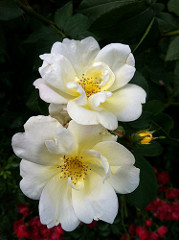

In [3]:
### *📌 Loading Images Using PIL (Pillow)*
### Pillow (`PIL`) is a common Python library for handling images.
from PIL import Image
import os

# Load an image
image_path = os.path.join(path,"flowers/rose/10090824183_d02c613f10_m.jpg")
image = Image.open(image_path)

# Display the image
image

## **2️⃣ Second Step: Finding Paths of All Images in a Folder**
To load an entire dataset, we need a **list of all image paths** inside a folder.

This could be achieved by glob.

In [4]:
import glob
folder_path = os.path.join(path, "flowers", "daisy", "*.jpg")

# Get paths of all .jpg images
image_files = glob.glob(folder_path)
print(image_files[:5])

['/kaggle/input/flowers-recognition/flowers/daisy/34670512115_af22cce24d_n.jpg', '/kaggle/input/flowers-recognition/flowers/daisy/8882282142_9be2524d38_m.jpg', '/kaggle/input/flowers-recognition/flowers/daisy/19280272025_57de24e940_m.jpg', '/kaggle/input/flowers-recognition/flowers/daisy/5133243796_44de429de5_m.jpg', '/kaggle/input/flowers-recognition/flowers/daisy/34695914906_961f92ffcd_n.jpg']


✅ **Now we have the full path for each image!**

## **3️⃣ Third Step: How to convert these images to tensors?**
PyTorch models require **tensors**, not raw images.  
To convert an image to a tensor, we use **`transforms.ToTensor()`**.

In [5]:
from torchvision import transforms

# Define transformation
transform = transforms.ToTensor()

# Load and convert image
image = Image.open(image_files[0])
image_tensor = transform(image)

# Show tensor shape
print(image_tensor.shape)  # (Channels, Height, Width)

torch.Size([3, 240, 159])


### ✅ **Great! This should be ready to be fed into a model, right?**  
####  **Sorry, life is not that easy.🫠**

## **📌 Do All Images Have the Same Shape?**
Before passing images to a model, we must ensure:
- **All images have the same size** (Height and Width)
- **No missing channels** (e.g., grayscale vs. RGB)

In [6]:
# Check shape of multiple images
for image_path in image_files[:5]:  # Check first 5 images
    img = Image.open(image_path)
    print(f"Image: {image_path}, Shape: {img.size}")  # Prints (Width, Height)

Image: /kaggle/input/flowers-recognition/flowers/daisy/34670512115_af22cce24d_n.jpg, Shape: (159, 240)
Image: /kaggle/input/flowers-recognition/flowers/daisy/8882282142_9be2524d38_m.jpg, Shape: (160, 240)
Image: /kaggle/input/flowers-recognition/flowers/daisy/19280272025_57de24e940_m.jpg, Shape: (240, 240)
Image: /kaggle/input/flowers-recognition/flowers/daisy/5133243796_44de429de5_m.jpg, Shape: (180, 240)
Image: /kaggle/input/flowers-recognition/flowers/daisy/34695914906_961f92ffcd_n.jpg, Shape: (240, 192)


## **📌 Why Do We Need Image Transformations?**
Ok, we can see now that we have to **resize all the images into the same size**.  
Otherwise, models wouldn't work because **they expect fixed input dimensions**.

But resizing is not the only operation we could do!  
We could also:
- **Convert an image to grayscale** 📷  
- **Crop the image** ✂️  
- **Rotate the image** 🔄  
- **Apply brightness adjustments** 💡  
- **Add noise for robustness** 🎭
- For others: https://pytorch.org/vision/0.10/transforms.html

PyTorch provides `torchvision.transforms` to easily apply these transformations.

These transformations, when applied on training data, are often called: **Augmentations**.

Augmentations are **image transformations** applied to:

✅ Improve **generalization** (prevent overfitting).  
✅ Increase **data variability** (expand dataset artificially).  
✅ Improve **robustness** (make the model handle different conditions).


Let's firstly try to resize the images we have above and convert them to grayscale.

In [7]:
from torchvision import transforms

# Define transformation
transform = transforms.Compose([
    transforms.Grayscale(),       # Make all the images gray scale
    transforms.Resize((64, 64)),  # Resize all images to 64x64
    transforms.ToTensor()
])

# Load and convert image
for i in range(10):
    image = Image.open(image_files[i])
    image_tensor = transform(image)

    # Show tensor shape
    print(image_tensor.shape)  # (Channels, Height, Width)

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])


✅ **Now, our images are consistent!**

# **📌 Let's Work with the Full Dataset**
Now, let's apply what we've learned to the **full dataset**.

Given you are working with torch, you can make a code for only **One Sample** and it should work for the whole dataset. So let's do that!

---

## **1️⃣ Understanding the Dataset Structure**
We have a **flower classification dataset** stored in the following structure:

```
flowers-recognition/
│── flowers/
│   │── daisy/
│   │── dandelion/
│   │── rose/
│   │── sunflower/
│   │── tulip/
```
Each folder contains images of the respective flower type.

---

## **2️⃣ Assigning Labels to Classes**
We have **5 categories**, so we assign **numerical labels** to them:

| Flower Name   | Label |
|--------------|-------|
| Daisy        | `0`   |
| Dandelion    | `1`   |
| Rose         | `2`   |
| Sunflower    | `3`   |
| Tulip        | `4`   |

#### ✅ **Our goal**: Read each image, apply transformations, and return both the **image** and its **corresponding label**.

---

## **3️⃣ First Step: Get the Paths of Each Class**
Before working with all images, let's focus on **one sample** then just make a loop.

In [8]:
import glob
import os
from PIL import Image
import torchvision.transforms as transforms

# Get all image paths from one category (e.g., Daisy)
category = "daisy"
folder_path = os.path.join(path, "flowers", category, "*.jpg")
image_paths = glob.glob(folder_path)

# Load one image
sample_image_path = image_paths[0]  # Take the first image
image = Image.open(sample_image_path)  # Open image

# Print original image size and channels
print(f"Original Image Size: {image.size}, Mode: {image.mode}")  # Mode is "RGB" for color images

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert to grayscale
    transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.ToTensor(),  # Convert to tensor
])

# Apply transformations
image_tensor = transform(image)

# Print transformed image shape
print(f"Transformed Image Shape: {image_tensor.shape}")  # (Channels, Height, Width)

# Define class labels
class_labels = {"daisy": 0, "dandelion": 1, "rose": 2, "sunflower": 3, "tulip": 4}
label = class_labels[category]

print(f"Image Label: {label}")  # Output: 0 (Daisy)

Original Image Size: (159, 240), Mode: RGB
Transformed Image Shape: torch.Size([1, 64, 64])
Image Label: 0


#### ✅ **Now, we have an image and its corresponding label!**  

# **📌 From Single Image Processing to a Dataset Class**
In the previous step, we **converted one image** from a raw format into a **model-ready tensor** with a label.

✅ But we don’t want to do this manually for every image.  
✅ Instead, we should **automate** this process inside `__getitem__()` in a **Dataset Class**.


---

# **📌 Let's See How a Dataset Class Looks**
A PyTorch Dataset class typically consists of **three main functions**:

| Function       | Purpose |
|---------------|------------------------------------------------|
| `__init__()`  | Loads all image paths & stores class labels. |
| `__len__()`   | Returns the total number of images. |
| `__getitem__()` | Loads, processes, and returns one image & label. |


#### Essentially, what we wrote earlier **should now go inside `__getitem__()`!**  

In [9]:
### **🔹 General Structure of a Dataset Class**
from torch.utils.data import Dataset
from PIL import Image
import glob

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir  # Dataset path
        self.transform = transform  # Transformations
        self.class_labels = {"daisy": 0, "dandelion": 1, "rose": 2, "sunflower": 3, "tulip": 4}

        # Get all image paths
        self.image_paths = []
        self.labels = []
        for class_name, label in self.class_labels.items():
            class_images = glob.glob(f"{root_dir}/{class_name}/*.jpg")  # Find all images
            self.image_paths.extend(class_images)
            self.labels.extend([label] * len(class_images))  # Assign labels

    def __len__(self):
        return len(self.image_paths)  # Total number of images

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]  # Get image path
        label = self.labels[idx]  # Get label

        # Load image using PIL
        image = Image.open(image_path)

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        return image, label  # Return processed image & label

In [10]:
# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(),  # Grayscale
    transforms.Resize((64, 64)),  # Resize all images to 64x64
    transforms.ToTensor(),  # Convert image to tensor
])

# Initialize it
dataset = CustomDataset(root_dir=os.path.join(path, "flowers") ,
                       transform=transform)

#### ✅ Now, **every time we call `dataset[idx]`, it will return an image & label, processed automatically!**  

---

# **📌 But Wait... This Reads One Image at a Time!**
Right now, our **Dataset Class** loads **one image at a time** when we call:
```python
image, label = dataset[0]  # Loads only one image
```
✅ **That’s great for understanding**, but when training a model, we need to process **multiple images at once** for efficiency.

❌ **Problem**: We need batches, not single images.  
✅ **Solution**: We use `DataLoader` to handle batching automatically.

# **📌 Introducing `DataLoader`**
A **DataLoader** helps in:
- **Batching**: Groups multiple samples together for faster processing.
- **Shuffling**: Randomizes data order to improve training.
- **Multi-threading**: Loads data efficiently in parallel.

| **Argument**     | **Description** |
|-----------------|---------------|
| `dataset` | The dataset object (e.g., `train_dataset`) |
| `batch_size` | Number of samples per batch (e.g., `32`) |
| `shuffle` | Whether to **randomly shuffle** data each epoch (`True` = better for training) |
| `num_workers` | Number of parallel **CPU workers** to load data faster |
| `collate_fn` | A function to **customize how data is stacked** (useful when data has variable sizes) |


![image.png](https://i.imgur.com/aHE3lnE.png)

In [11]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 32

# Create DataLoader
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Get a batch of training images
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels}")

Batch shape: torch.Size([32, 1, 64, 64]), Labels: tensor([2, 1, 1, 1, 0, 2, 0, 3, 1, 0, 2, 3, 1, 3, 4, 0, 2, 3, 3, 4, 3, 1, 2, 1,
        0, 4, 1, 1, 3, 1, 2, 1])


#### ✅ **Now, instead of reading one image at a time, we process an entire batch! This can be now fed into a model.**

---

# Another Example

# **📌 Skin Cancer ISIC Dataset**
We will now work with the **Skin Cancer ISIC** dataset, which contains images of different skin lesions.

---

# **📌 Dataset Structure**
The dataset consists of **two folders**:  
✅ `Train/` → Contains images for training.  
✅ `Test/` → Contains images for evaluation.

Each folder contains **9 categories of skin lesions**:

```
Skin_Cancer_ISIC/
│── Train/
│   │── actinic keratosis/
│   │── basal cell carcinoma/
│   │── dermatofibroma/
│   │── melanoma/
│   │── nevus/
│   │── pigmented benign keratosis/
│   │── seborrheic keratosis/
│   │── squamous cell carcinoma/
│   │── vascular lesion/
│── Test/
│   │── actinic keratosis/
│   │── basal cell carcinoma/
│   │── dermatofibroma/
│   │── melanoma/
│   │── nevus/
│   │── pigmented benign keratosis/
│   │── seborrheic keratosis/
│   │── squamous cell carcinoma/
│   │── vascular lesion/
```

✅ **Each folder represents a different type of skin lesion.**  
✅ **Our goal** is to classify images into these 9 categories.

---

# **📌 Assigning Labels**
We assign a **numerical label** to each class:

| Skin Lesion Name                 | Label |
|----------------------------------|------|
| Actinic Keratosis               | `0`  |
| Basal Cell Carcinoma            | `1`  |
| Dermatofibroma                  | `2`  |
| Melanoma                        | `3`  |
| Nevus                           | `4`  |
| Pigmented Benign Keratosis      | `5`  |
| Seborrheic Keratosis            | `6`  |
| Squamous Cell Carcinoma         | `7`  |
| Vascular Lesion                 | `8`  |

✅ **Now, let’s define the dataset class!**

---

In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")

print("Path to dataset files:", path)

100%|██████████| 786M/786M [00:38<00:00, 21.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nodoubttome/skin-cancer9-classesisic/versions/1


In [13]:
from torch.utils.data import Dataset
from PIL import Image
import glob

class SkinCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir  # Dataset path
        self.transform = transform  # Transformations
        self.class_labels = {
            "actinic keratosis": 0, "basal cell carcinoma": 1, "dermatofibroma": 2,
            "melanoma": 3, "nevus": 4, "pigmented benign keratosis": 5,
            "seborrheic keratosis": 6, "squamous cell carcinoma": 7, "vascular lesion": 8
        }

        # Get all image paths
        self.image_paths = []
        self.labels = []
        for class_name, label in self.class_labels.items():
            class_images = glob.glob(f"{root_dir}/{class_name}/*.jpg")  # Find all images
            self.image_paths.extend(class_images)
            self.labels.extend([label] * len(class_images))  # Assign labels

    def __len__(self):
        return len(self.image_paths)  # Total number of images

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]  # Get image path
        label = self.labels[idx]  # Get label

        # Load image using PIL
        image = Image.open(image_path)

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        return image, label  # Return processed image & label

In [14]:
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images
    transforms.RandomRotation(15),  # Rotate images randomly within ±15 degrees
    transforms.ColorJitter(brightness=0.2),  # Adjust brightness randomly
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),  # value for each channel
])

# Validation and testing data typically don’t require augmentations, as we only evaluate the model performance on these sets.
# Instead, we apply basic transformations to prepare the images.
transform_valid_test = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])


# Initialize dataset for Train
train_path = os.path.join(path, "Skin cancer ISIC The International Skin Imaging Collaboration", "Train")
test_path = os.path.join(path, "Skin cancer ISIC The International Skin Imaging Collaboration", "Test")

train_dataset = SkinCancerDataset(train_path, transform=transform)
test_dataset = SkinCancerDataset(test_path, transform=transform_valid_test)

# Create DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Get a batch of training images
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels}")

Batch shape: torch.Size([32, 3, 64, 64]), Labels: tensor([1, 5, 0, 4, 5, 8, 5, 5, 3, 7, 4, 0, 3, 4, 7, 5, 5, 6, 4, 3, 3, 8, 3, 1,
        7, 5, 1, 4, 4, 2, 3, 3])


## **🔹 Now You Know How to Split into Train and Test!**
To create training and testing datasets, we **split the image paths** and create **two datasets and two dataloaders**.


## 📌 **Another easier approach for datasets organized in subfolders**

When working with **image classification datasets** organized in subfolders, **`ImageFolder`** is a great **built-in PyTorch dataset loader** that automatically assigns labels based on folder names.

---

**Dataset Structure Expected by `ImageFolder`:**
```
Dataset/
│── Class_A/
│   │── image_1.jpg
│   │── image_2.jpg
│── Class_B/
│   │── image_3.jpg
│   │── image_4.jpg
```
- **Class names (folder names) become labels** (`Class_A = 0`, `Class_B = 1`)
- **No need to manually extract file paths and labels!**

---






Given our dataset here follow this structure, we can, instead of writing a custom `Dataset` class, **directly load images** using `ImageFolder`!

In [15]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os

# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images
    transforms.RandomRotation(15),  # Rotate images randomly within ±15 degrees
    transforms.ColorJitter(brightness=0.2),  # Adjust brightness randomly
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),  # value for each channel
])

# Validation and testing data typically don’t require augmentations, as we only evaluate the model performance on these sets.
# Instead, we apply basic transformations to prepare the images.
transform_valid_test = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])


# Initialize dataset for Train
train_path = os.path.join(path, "Skin cancer ISIC The International Skin Imaging Collaboration", "Train")
test_path = os.path.join(path, "Skin cancer ISIC The International Skin Imaging Collaboration", "Test")

train_dataset = ImageFolder(train_path, transform=transform)                                                    ## Replaced SkinCancerDataset with ImageFolder
test_dataset = ImageFolder(test_path, transform=transform_valid_test)                                           ## Replaced SkinCancerDataset with ImageFolder

# Create DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Get a batch of training images
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels}")

Batch shape: torch.Size([32, 3, 64, 64]), Labels: tensor([5, 8, 3, 1, 5, 3, 0, 3, 6, 6, 3, 6, 4, 3, 4, 2, 3, 3, 1, 3, 1, 3, 0, 4,
        3, 7, 8, 5, 4, 7, 3, 4])


#### That's it! No need for a custom dataset class here!

# **📌 Handling Datasets with Non-Standard Structures**
Sometimes, datasets are structured in **non-standard ways**, making it harder to assign labels directly from folder names.  


### **Example: Weird Dataset Structure**
In this case, instead of having separate folders for `smoking` and `notsmoking`, the filenames themselves indicate the class:

```
Smoking_Dataset/
│── Training/
│   │── Training/
│   │   │── notsmoking_0006.jpg
│   │   │── smoking_0007.jpg
│── Validation/
│   │── Validation/
│   |   │── notsmoking_0012.jpg
│   |   │── smoking_0015.jpg
│── Testing/
│   │── Testing/
│   |   │── notsmoking_0032.jpg
│   |   │── smoking_0034.jpg
```

---

In [16]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sujaykapadnis/smoking")

print("Path to dataset files:", path)

100%|██████████| 63.8M/63.8M [00:04<00:00, 16.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sujaykapadnis/smoking/versions/5


- Let's extract the labels outside the dataset class for simplicity

In [17]:
import os
import glob
from tqdm import tqdm

# Define dataset path
dataset_path = os.path.join(path, "Training", "Training")
# Get all image paths
train_image_paths = glob.glob(f"{dataset_path}/*.jpg")

# Define dataset path
dataset_path = os.path.join(path, "Validation", "Validation")
# Get all image paths
valid_image_paths = glob.glob(f"{dataset_path}/*.jpg")

# Define dataset path
dataset_path = os.path.join(path, "Testing", "Testing")
# Get all image paths
test_image_paths = glob.glob(f"{dataset_path}/*.jpg")


train_labels = []
valid_labels = []
test_labels = []

for path in tqdm(train_image_paths):
    prefix  = path.split("/")[-1].split("_")[0]                 # "./Training/smoking_0007.jpg" → "smoking_0007.jpg"  → "smoking"
    label = 1 if prefix == "smoking" else 0                     # Assign label
    train_labels.append(label)                                  # Store label

for path in tqdm(valid_image_paths):
    prefix = path.split("/")[-1].split("_")[0]
    label = 1 if prefix == "smoking" else 0
    valid_labels.append(label)

for path in tqdm(test_image_paths):
    prefix = path.split("/")[-1].split("_")[0]
    label = 1 if prefix == "smoking" else 0
    test_labels.append(label)

100%|██████████| 224/224 [00:00<00:00, 525167.19it/s]


✅ Now, image paths and labels are ready for the dataset class! 🎯

In [18]:
from torch.utils.data import Dataset
from PIL import Image

class SmokingDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths  # List of image paths
        self.labels = labels  # Corresponding labels
        self.transform = transform  # Transformations to apply

    def __len__(self):
        return len(self.image_paths)  # Total number of images

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]  # Get image path
        label = self.labels[idx]  # Get corresponding label

        # Load image
        image = Image.open(image_path)

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        return image, label  # Return processed image and its label

In [26]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])


transform_valid_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Initialize datasets
train_dataset = SmokingDataset(train_image_paths, train_labels, transform=transform)
valid_dataset = SmokingDataset(valid_image_paths, valid_labels, transform=transform_valid_test)
test_dataset = SmokingDataset(test_image_paths, test_labels, transform=transform_valid_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get a batch of training images
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels}")

Batch shape: torch.Size([32, 3, 224, 224]), Labels: tensor([1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 1])


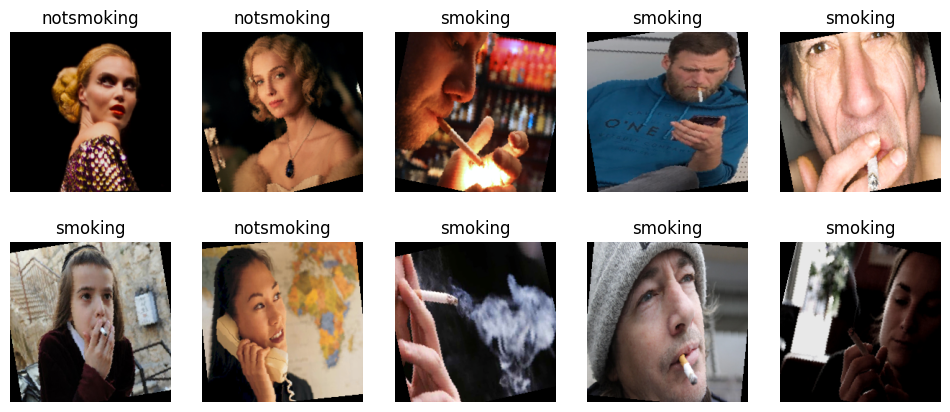

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# ImageNet mean and std
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Show images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
classes = ['notsmoking', 'smoking']

for i, ax in enumerate(axes.flat):
    img = images[i].numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)

    # Unnormalize using ImageNet mean/std
    img = img * std + mean
    img = np.clip(img, 0, 1)  # Ensure pixel values are in [0, 1]

    ax.imshow(img)
    ax.set_title(classes[labels[i]])
    ax.axis("off")

plt.show()

In [29]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim


# Load a pretrained ResNet
model = models.resnet18(pretrained=True)

# Replace the final fully connected layer to match your number of classes
num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [30]:
for param in model.parameters():
    param.requires_grad = False

# Only train the final layer
for param in model.fc.parameters():
    param.requires_grad = True

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

num_epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [36]:

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total * 100  # percentage

    # Validation
    model.eval()
    val_loss_running = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss_running += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_loss_running / len(valid_loader.dataset)
    val_acc = val_correct / val_total * 100

    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")

Epoch 1/10: Train Loss=0.4680, Val Loss=0.4284, Train Acc=76.12%, Val Acc=77.78%
Epoch 2/10: Train Loss=0.4579, Val Loss=0.3921, Train Acc=77.79%, Val Acc=82.22%
Epoch 3/10: Train Loss=0.3970, Val Loss=0.3792, Train Acc=82.68%, Val Acc=83.33%
Epoch 4/10: Train Loss=0.3948, Val Loss=0.3560, Train Acc=83.66%, Val Acc=83.33%
Epoch 5/10: Train Loss=0.3797, Val Loss=0.3997, Train Acc=84.92%, Val Acc=80.56%
Epoch 6/10: Train Loss=0.4135, Val Loss=0.4166, Train Acc=81.56%, Val Acc=80.00%
Epoch 7/10: Train Loss=0.3734, Val Loss=0.4170, Train Acc=84.78%, Val Acc=80.00%
Epoch 8/10: Train Loss=0.3842, Val Loss=0.4450, Train Acc=82.40%, Val Acc=77.78%
Epoch 9/10: Train Loss=0.3749, Val Loss=0.3900, Train Acc=83.52%, Val Acc=80.00%
Epoch 10/10: Train Loss=0.3608, Val Loss=0.4200, Train Acc=84.64%, Val Acc=80.56%


In [33]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct/total:.4f}")

Test Accuracy: 0.7902


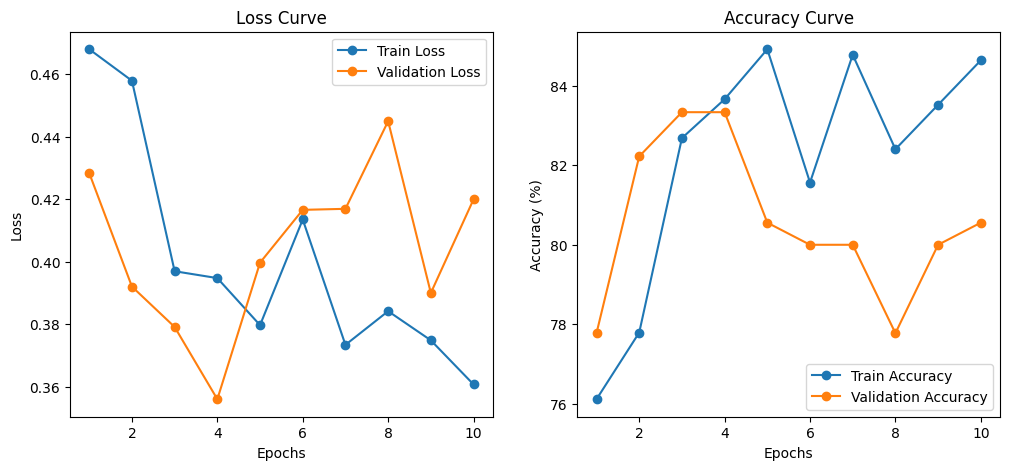

In [37]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


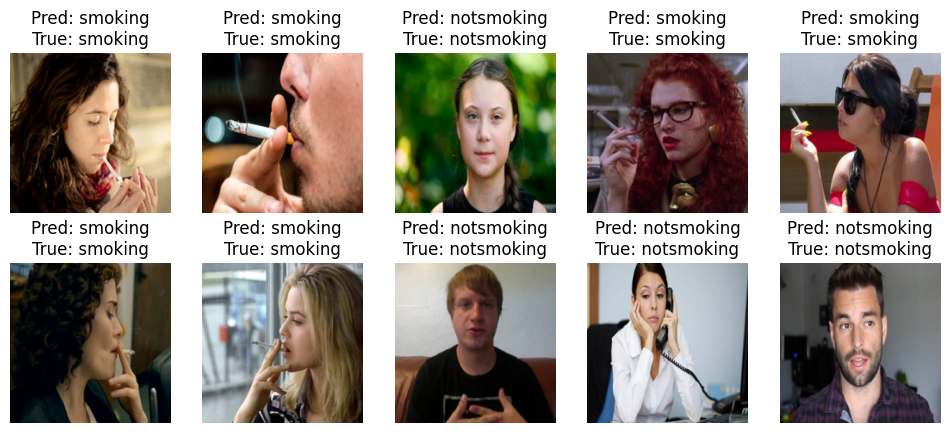

In [40]:
classes = ['notsmoking', 'smoking']

# Get a batch from test_loader
images, labels = next(iter(test_loader))

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
model.eval()
with torch.no_grad():
    images_device = images.to(device)
    outputs = model(images_device)
    _, preds = torch.max(outputs, 1)
    preds = preds.cpu()

for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

    # If normalized with ImageNet stats, unnormalize
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    ax.set_title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}")
    ax.axis("off")

plt.show()

## **📌 Final Note: Data Formats Can Vary**
When working with datasets, **the structure may differ** based on how the labels are stored.  

✅ **Common ways labels are provided**:
- **Folder names** → Each folder represents a class (as we saw).
- **CSV file** → Labels are stored in a `data.csv` file with filenames.
- **JSON file** → Labels are stored in a `labels.json` file.
- **Separate annotation files** → Some datasets use `.txt` or `.xml` annotations.

### **🔹 How to Handle This?**
✅ **Always explore the dataset structure first** before writing code.  
✅ Check:
- 📂 **Are images inside class folders?**
- 📄 **Is there a CSV/JSON file with labels?**
- 🔄 **Do filenames contain class names?**

Once you understand the dataset, **write the correct logic to retrieve paths and labels.**  


### Contributed by: Mohamed Eltayeb